**Simulated Annealing for the predator-prey model**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [23]:
# import data 
df = pd.read_csv("predator-prey-data.csv", delimiter = ",")
t = np.array(df["t"])
x = df["x"]
y = df["y"]

data = df

In [75]:
def lotka_volterra(init, t, alpha, beta, delta, gamma):
    x, y = init
    dxdt = alpha * x - beta * x * y 
    dydt = delta * x * y - gamma * y
    return dxdt, dydt

def abs_residual(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    x_and_y = np.vstack((x,y)).T

    t_data = np.array(data['t'],dtype=float)
    
    y0 = [x[0], y[0]]       
    model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))

    return np.linalg.norm(model - x_and_y)**2

def loss_function_res(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    t_data = np.array(data['t'],dtype=float)
    # t_dense = np.linspace(t_data[0], t_data[-1], 1000)


    y0 = [x[0], y[0]]
    model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))

    loss = 0
    for i in range(len(t)):
        x_data = x[i]
        x_model = model[i,0]

        y_data = y[i]
        y_model = model[i,1]

        res = (x_data - x_model)**2 + (y_data - y_model)**2
        loss += res
    return loss

In [60]:
def simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, data):
    """"
    Performs simulated annealing to find global optimal values.
    init_guess = initial guess (array of real numbers, indicating alpha, beta, delta, gamma, x0 and y0)
    n_iterations = number of iterations to be performed
    std = standard deviation of the normal distribution that determines new possible solutions (step size)
    min_function = objective function (to be minimized)
    T_start = starting temperature for the cooling schedule
    a, b = variables for the cooling schedule
    data = the data to be fitted

    Returns the final solution and the fitness value of that solution
    """

    prev_sol = init_guess
    T = T_start
    
    for n in range(n_iterations):
        # create a new solution
        new_sol = prev_sol + np.random.normal(0, step, size=len(prev_sol))

        # determine whether new_sol is accepted 
        u = np.random.uniform()

        fit_new_sol = min_function(new_sol,data)
        fit_prev_sol = min_function(prev_sol,data)

        # use Boltzman distribution
        if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1): 
            prev_sol = new_sol
        
        # decrease the temperature
        n += 1
        T = a/np.log(n + b)

    return prev_sol, min_function(prev_sol,data)

In [61]:
def plot_fit(params, df):
    alpha = params[0]
    beta = params[1]
    delta = params[2]
    gamma = params[3]

    y0 = [x[0], y[0]]
     
    time = np.array(df['t'])
    t = np.linspace(time[0], time[-1], 1000)

    output = odeint(lotka_volterra, y0, t, args=(alpha, beta, delta, gamma))

    plt.title("Preditor-Prey Dynamics")
    plt.ylabel("Population size")
    plt.xlabel("Time")
    plt.grid()

    plt.plot(t,output[:,0], color="r")
    plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

    plt.show()

    plt.plot(t,output[:,1], color="b")
    plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')

    plt.show()

In [62]:
np.random.seed(5)

init_guess = np.random.uniform(0,1,4)
n_iterations = 13000
std = 0.5
min_function = abs_residual
T_start = 20
a = 3
b = 10

params, err = simulated_annealing(init_guess, n_iterations, std, min_function, T_start, a, b, data)

/Users/loesbijman/anaconda3/envs/my-env/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4025304020929D+01   r2 =  0.3892610871187D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4025304020929D+01   r2 =  0.3892610871187D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4025304020929D+01   r2 =  0.3223014027859D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4025304020929D+01   r2 =  0.3223014027859D-15
 lsoda--  warning..internal t (=r1) 

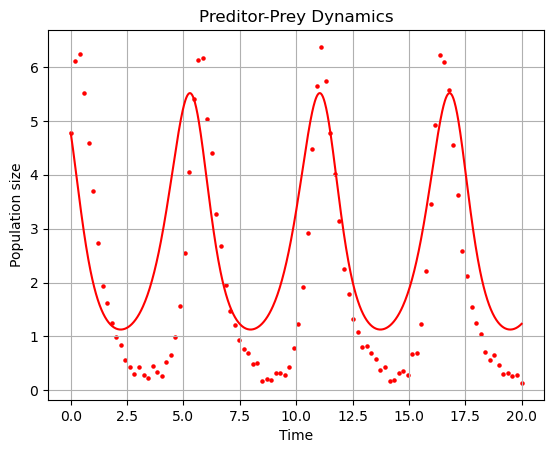

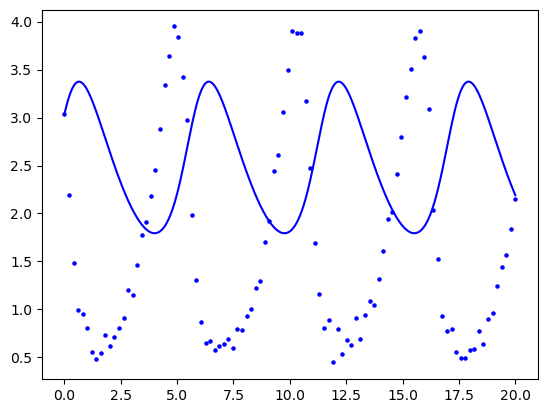

In [63]:
plot_fit(params, df)

**Tuning**

In [78]:
def multi_runs(runs, init_guess, n_iterations, step, min_function, T_start, a, b, data):
    """
    Runs the simulated annealing algorithm multiple times, with random initial guess.
    Returns:
    err_temp = list of all errors (determined with min_function)
    best_sol = solution with lowest residual over all runs
    err_best = residual of best solution
    """
    err_temp = []
    for _ in range(runs):
        init_guess = np.random.uniform(0,1,4)
        params, err = simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, data)
        err_temp.append(err)

        if err < float('inf'):
            best_sol = params
            err_best = err
    return err_temp, best_sol, err_best

In [82]:
# Parameter tuning for step size

n_iterations = 1300
min_function = loss_function_res
T_start = 2
a = 3
b = 10
data = df

step_range = np.arange(0.01,2,0.2)
runs = 30

err_list = []
std_list = []
best_err_so_far = float('inf')

for step in step_range:
    print(step)

    err_temp, best_sol, err_best = multi_runs(runs, init_guess, n_iterations, step, min_function, T_start, a, b, data)

    # save overall best solution and its step size
    if err_best < best_err_so_far:
        best_err_so_far = err_best
        best_sol_total = best_sol
        best_step = step

    err_list.append(np.mean(err_temp))
    std_list.append(np.std(err_temp))

0.01


/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_95715/3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


0.21000000000000002
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1887230796782D+02   r2 =  0.1684709540576D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1887230796782D+02   r2 =  0.1684709540576D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1887230796782D+02   r2 =  0.1684709540576D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1887230796782D+02   r2 =  0.1684709540576D-14
 lsoda--  warnin

KeyboardInterrupt: 

In [80]:
print(best_sol_total)
print(best_err_so_far)

[-0.06931534  0.00460402 -0.73882777  0.98105193]
832.8374008750432


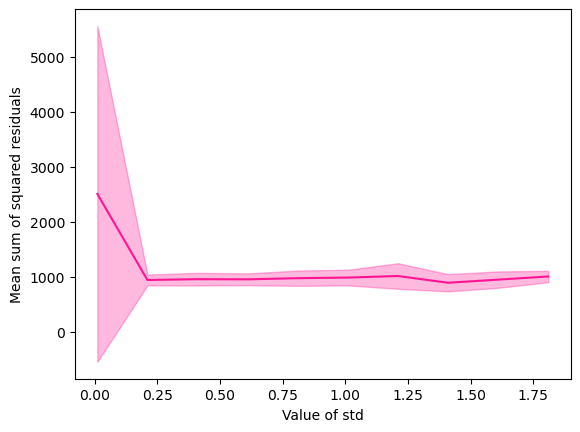

In [81]:
plt.plot(step_range, err_list, color = 'deeppink')
plt.fill_between(step_range, np.array(err_list)-np.array(std_list), np.array(err_list)+np.array(std_list), color = 'deeppink', alpha = 0.3)
plt.xlabel('Value of std')
plt.ylabel('Mean sum of squared residuals')
plt.show()

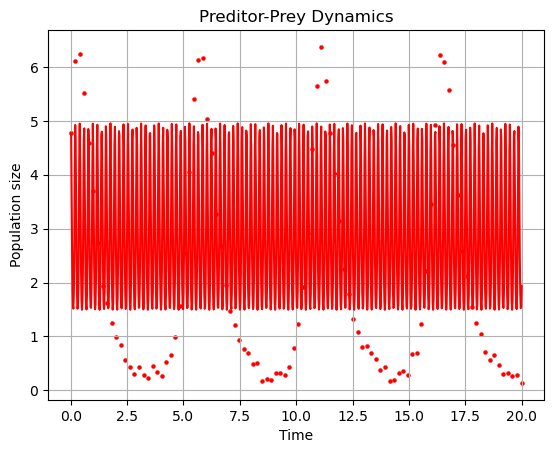

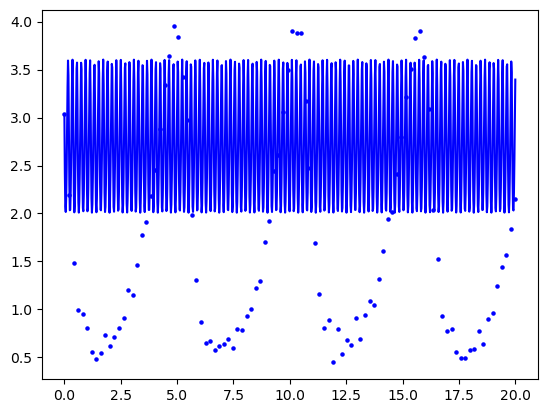

In [68]:
# Plot the best solution

plot_fit(best_sol_total,data)

**Stochastic hill climbing**

Chooses at random from uphill moves (steepness determines probability of selection)

In [96]:
def stoch_hill_climb(init_guess, std, min_function, data, n_iterations):
    prev_sol = init_guess

    for _ in range(n_iterations):
        # create a new solution
        new_sol = []
        for param in prev_sol:
            new_param = param + np.random.normal(0,std)
            new_sol.append(new_param)

        # determine whether new_sol is accepted
        u = np.random.uniform()
        if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):
            prev_sol = new_sol

    return prev_sol

In [99]:
init_guess = np.ones(4)
std = 0.1
min_function = abs_residual
data = df
n_iterations = 10000

params_shc = stoch_hill_climb(init_guess,std,min_function,data,n_iterations)

/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_54516/2068039739.py:13: RuntimeWarning: overflow encountered in exp
  if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):
/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_54516/2068039739.py:13: RuntimeWarning: invalid value encountered in scalar divide
  if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):


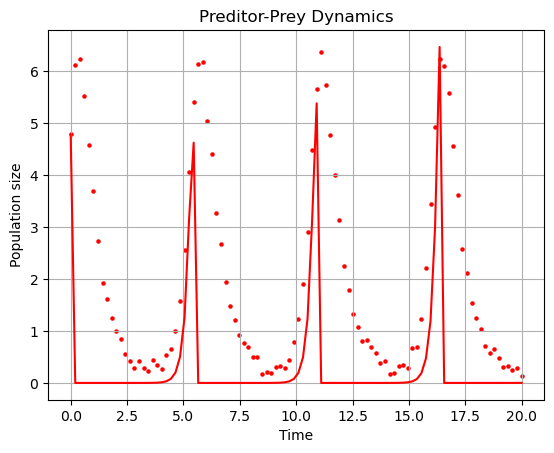

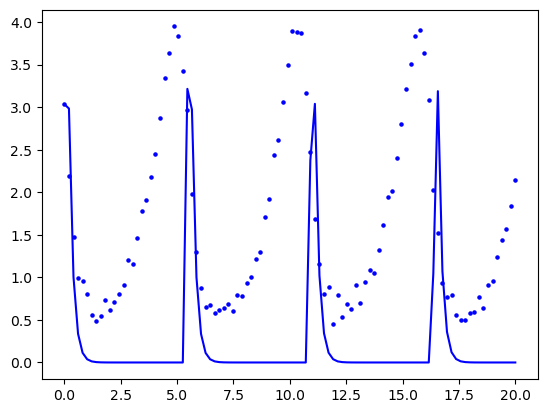

In [100]:
alpha_shc = params_shc[0]
beta_shc = params_shc[1]
delta_shc = params_shc[2]
gamma_shc = params_shc[3]

y0 = [x[0], y[0]]
t = np.linspace(t[0], t[-1], num=len(t))

output_shc = odeint(lotka_volterra, y0, t, args=(alpha_shc, beta_shc, delta_shc, gamma_shc))

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()

plt.plot(t,output[:,0], color="r")
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

plt.show()

plt.plot(t,output[:,1], color="b")
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')

plt.show()